In [1]:
import os

source_path = 'C:\\Users\\sumey\\Downloads\\kaggle.json'
print(f"File exists: {os.path.isfile(source_path)}")


File exists: True


In [2]:
import os
import shutil

# Define the source and destination paths
source_path = r'C:\Users\sumey\Downloads\kaggle.json'
destination_dir = os.path.expanduser('~/.kaggle')
destination_path = os.path.join(destination_dir, 'kaggle.json')

# Check if source file exists
if not os.path.isfile(source_path):
    raise FileNotFoundError(f"The source file does not exist: {source_path}")

# Create the .kaggle directory if it doesn't exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Check if the file already exists in the destination directory
if not os.path.isfile(destination_path):
    # Copy the kaggle.json file to the .kaggle directory
    shutil.copy(source_path, destination_path)
    print(f'kaggle.json has been copied to {destination_path}')
else:
    print(f'kaggle.json already exists in {destination_path}. Skipping copy.')

kaggle.json already exists in C:\Users\sumey/.kaggle\kaggle.json. Skipping copy.


In [3]:
!pip install kaggle


In [2]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia 

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
... resuming from 146800640 bytes (2316564795 bytes left) ...




  6%|▌         | 140M/2.29G [00:00<?, ?B/s]
  6%|▌         | 141M/2.29G [00:02<1:13:51, 523kB/s]
  6%|▌         | 142M/2.29G [00:02<45:39, 845kB/s]  
  6%|▌         | 143M/2.29G [00:03<35:59, 1.07MB/s]
  6%|▌         | 144M/2.29G [00:04<31:59, 1.20MB/s]
  6%|▌         | 145M/2.29G [00:04<26:06, 1.48MB/s]
  6%|▌         | 146M/2.29G [00:04<20:59, 1.83MB/s]
  6%|▋         | 147M/2.29G [00:05<17:54, 2.15MB/s]
  6%|▋         | 148M/2.29G [00:05<15:54, 2.42MB/s]
  6%|▋         | 149M/2.29G [00:05<14:45, 2.60MB/s]
  6%|▋         | 150M/2.29G [00:06<13:34, 2.83MB/s]
  6%|▋         | 151M/2.29G [00:06<13:45, 2.79MB/s]
  6%|▋         | 152M/2.29G [00:06<13:09, 2.92MB/s]
  7%|▋         | 153M/2.29G [00:07<11:47, 3.26MB/s]
  7%|▋         | 154M/2.29G [00:07<11:23, 3.37MB/s]
  7%|▋         | 155M/2.29G [00:07<12:04, 3.18MB/s]
  7%|▋         | 156M/2.29G [00:08<13:04, 2.93MB/s]
  7%|▋         | 157M/2.29G [00:08<11:48, 3.25MB/s]
  7%|▋         | 158M/2.29G [00:08<10:54, 3.51MB/s]
  7%|▋         | 

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'chest-xray-pneumonia.zip'

In [5]:
import zipfile

# Path to the zip file
zip_file_path = './chest-xray-pneumonia.zip'

# Directory where you want to extract the files
output_directory = './chest_xray'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_directory)

print(f"Files successfully extracted to {output_directory}")


Files successfully extracted to ./chest_xray


Contents of base directory: ['chest_xray', 'test', 'train', 'val', '__MACOSX']
Contents of training directory: ['NORMAL', 'PNEUMONIA']
Contents of testing directory: ['NORMAL', 'PNEUMONIA']
Contents of validation directory: ['NORMAL', 'PNEUMONIA']
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 124 images belonging to 2 classes.
Limited training dataset: 48 images, 48 labels
Limited validation dataset: 16 images, 16 labels
Shape of limited train images: (48, 256, 256, 3)
Shape of limited train labels: (48,)


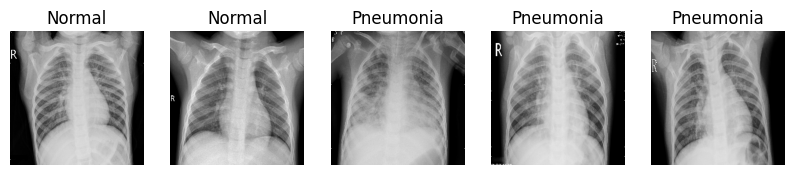

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define base directory
base_dir = r'C:\Users\sumey\Desktop\visual_projects\cycleGAN_for_detection_of_pnumonia\notebooks\chest_xray\chest_xray'


# List contents of the base directory
print("Contents of base directory:", os.listdir(base_dir))

# Define paths for training, testing, and validation datasets
train_dir = os.path.join(base_dir, r'train')
test_dir = os.path.join(base_dir, r'test')
val_dir = os.path.join(base_dir, r'val')

# Verify the contents of each directory
print("Contents of training directory:", os.listdir(train_dir))
print("Contents of testing directory:", os.listdir(test_dir))
print("Contents of validation directory:", os.listdir(val_dir))
# Define the strategy for distributed training, if applicable
strategy = tf.distribute.MirroredStrategy()
# Set image size and other hyperparameters
BUFFER_SIZE = 64000
BATCH_SIZE = 8 * strategy.num_replicas_in_sync  # Batch size for distributed training
EPOCHS = 3
latent_dim = 128
input_size = [256, 256, 3]  # 512x512 RGB images
image_size = (256, 256)  # Size for resizing images

# Initialize ImageDataGenerator for data preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Split the dataset for validation
)

# Function to limit dataset to a specific number of batches
def limit_batches(dataset, n_batches):
    limited_images = []
    limited_labels = []
    batch_counter = 0
    for batch in dataset:
        images, labels = batch  # Get images and labels
        limited_images.extend(images)
        limited_labels.extend(labels)
        batch_counter += 1
        if batch_counter >= n_batches:
            break
    return np.array(limited_images), np.array(limited_labels)

# Define the number of desired samples
desired_train_samples = 50
desired_val_samples = 20

# Calculate the number of batches required for each dataset
n_train_batches = desired_train_samples // BATCH_SIZE
n_val_batches = desired_val_samples // BATCH_SIZE

# For training dataset
train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Include labels
    shuffle=True,
    subset='training'
)

# Limit the training dataset
limited_train_images, limited_train_labels = limit_batches(train_dataset, n_train_batches)

# For validation dataset
val_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Include labels
    shuffle=True,
    subset='validation'
)
 #For test dataset
test_dataset = train_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Include labels
    shuffle=True,
    subset='validation'
)

# Limit the validation dataset
limited_val_images, limited_val_labels = limit_batches(val_dataset, n_val_batches)

# Check the output of the limited dataset
print(f"Limited training dataset: {len(limited_train_images)} images, {len(limited_train_labels)} labels")
print(f"Limited validation dataset: {len(limited_val_images)} images, {len(limited_val_labels)} labels")

# Print the shape of images and labels
print("Shape of limited train images:", limited_train_images.shape)  # Should be (batch_size, height, width, channels)
print("Shape of limited train labels:", limited_train_labels.shape)  # Should be (batch_size,)

# Visualize the limited dataset
def visualize_data(images, labels, num_images=5):
    plt.figure(figsize=(10, 5))
    
    num_images = min(num_images, images.shape[0])

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])  # Display image
        plt.title('Pneumonia' if labels[i] == 1 else 'Normal')  # Set title based on label
        plt.axis('off')

    plt.show()

# Visualizing a few images from the limited training dataset
visualize_data(limited_train_images, limited_train_labels, num_images=5)


In [2]:
import tensorflow as tf
from tensorflow.keras import layers

def build_generator():
    inputs = layers.Input(shape=(256, 256, 3))

    # Encoder
    x = layers.Conv2D(64, kernel_size=7, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)  # Add normalization
    x = layers.ReLU()(x)

    # Downsampling
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)  # Add normalization
    x = layers.ReLU()(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)  # Add normalization
    x = layers.ReLU()(x)

    # Bottleneck
    for _ in range(9):
        res = x
        x = layers.Conv2D(256, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)  # Add normalization
        x = layers.ReLU()(x)
        x = layers.Conv2D(256, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)  # Add normalization
        x = layers.add([x, res])  # Residual connection

    # Upsampling
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)  # Add normalization
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)  # Add normalization
    x = layers.ReLU()(x)

    outputs = layers.Conv2D(3, kernel_size=7, padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs, outputs)
def build_discriminator():
    inputs = layers.Input(shape=(256, 256, 3))
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(512, kernel_size=4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(1)(x)

    return tf.keras.Model(inputs, outputs)

# Instantiate generators and discriminators
generator_G = build_generator()  # Normal to Pneumonia
generator_F = build_generator()  # Pneumonia to Normal
discriminator_X = build_discriminator()  # Normal images
discriminator_Y = build_discriminator()  # Pneumonia images

In [3]:
# Define loss functions
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return loss_object(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = loss_object(tf.ones_like(real_output), real_output)
    fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
    return (real_loss + fake_loss) * 0.5

def cycle_loss(real_image, cycled_image, lambda_cycle=10):
    return lambda_cycle * tf.reduce_mean(tf.abs(real_image - cycled_image))
def perceptual_loss(real_image, cycled_image):
    # Example: Use a pre-trained model to extract features
    model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    model.trainable = False  # Freeze the model
    real_features = model(real_image)
    cycled_features = model(cycled_image)
    return tf.reduce_mean(tf.abs(real_features - cycled_features))

def total_cycle_loss(real_image, cycled_image, lambda_cycle=10):
    return lambda_cycle * tf.reduce_mean(tf.abs(real_image - cycled_image)) + perceptual_loss(real_image, cycled_image)


# Define optimizers
generator_G_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_F_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [16]:
import time
import tensorflow as tf

# Assuming that the generator_G, generator_F, discriminator_X, discriminator_Y are already defined models
# Also assuming that generator_loss, cycle_loss, discriminator_loss are pre-defined loss functions
# And optimizers are defined: generator_G_optimizer, generator_F_optimizer, discriminator_X_optimizer, discriminator_Y_optimizer

@tf.function
def train_step(real_x, real_y):
    start_time = time.time()
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X to Y
        fake_y = generator_G(real_x)
        cycled_x = generator_F(fake_y)  # Translate Y back to X

        # Generator F translates Y to X
        fake_x = generator_F(real_y)
        cycled_y = generator_G(fake_x)  # Translate X back to Y

        # Discriminator output
        disc_real_x = discriminator_X(real_x)
        disc_real_y = discriminator_Y(real_y)
        disc_fake_x = discriminator_X(fake_x)
        disc_fake_y = discriminator_Y(fake_y)

        # Calculate the loss
        gen_G_loss = generator_loss(disc_fake_y)
        gen_F_loss = generator_loss(disc_fake_x)
        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)

        # Total generator loss
        total_gen_G_loss = gen_G_loss + total_cycle_loss
        total_gen_F_loss = gen_F_loss + total_cycle_loss

        # Discriminator loss
        disc_X_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_Y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        print(f"fake_y shape: {fake_y.shape}, fake_x shape: {fake_x.shape}, cycled_x shape: {cycled_x.shape}, cycled_y shape: {cycled_y.shape}")
    ...
    # Calculate the gradients
    generator_G_gradients = tape.gradient(total_gen_G_loss, generator_G.trainable_variables)
    generator_F_gradients = tape.gradient(total_gen_F_loss, generator_F.trainable_variables)
    discriminator_X_gradients = tape.gradient(disc_X_loss, discriminator_X.trainable_variables)
    discriminator_Y_gradients = tape.gradient(disc_Y_loss, discriminator_Y.trainable_variables)

    # Apply the gradients to the optimizers
    generator_G_optimizer.apply_gradients(zip(generator_G_gradients, generator_G.trainable_variables))
    generator_F_optimizer.apply_gradients(zip(generator_F_gradients, generator_F.trainable_variables))
    discriminator_X_optimizer.apply_gradients(zip(discriminator_X_gradients, discriminator_X.trainable_variables))
    discriminator_Y_optimizer.apply_gradients(zip(discriminator_Y_gradients, discriminator_Y.trainable_variables))
    
    end_time = time.time()
    print(f"Training step took {end_time - start_time:.2f} seconds.")
    
    return total_gen_G_loss, total_gen_F_loss, disc_X_loss, disc_Y_loss, fake_x, fake_y


# Main training loop
EPOCHS = 1  # Define your number of epochs here

# Here we use the limited training and validation datasets
limited_train_dataset = tf.data.Dataset.from_tensor_slices((limited_train_images, limited_train_labels))
limited_val_dataset = tf.data.Dataset.from_tensor_slices((limited_val_images, limited_val_labels))

# Shuffle and batch the datasets
limited_train_dataset = limited_train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
limited_val_dataset = limited_val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Train the model on the limited dataset
# Train the model on the limited dataset
for epoch in range(EPOCHS):
    start_time = time.time()
    print(f"Epoch {epoch + 1}/{EPOCHS} started")

    # Create an iterator for the training and validation datasets
    train_iterator = iter(limited_train_dataset)
    val_iterator = iter(limited_val_dataset)

    # Total batches calculated as the minimum of the lengths of the two datasets
    total_batches = min(len(limited_train_dataset), len(limited_val_dataset))
    print(f"Total batches in this epoch: {total_batches}")

    for batch in range(total_batches):
        # Get the next batch from both the training and validation datasets
        try:
            real_x = next(train_iterator)
            real_y = next(val_iterator)
        except StopIteration:
            break  # Break if one of the datasets is exhausted

        print(f"Processing epoch {epoch + 1}, batch {batch + 1}/{total_batches}")  # Debugging print
        
        # Check if real_x and real_y might be tuples; unpack if necessary
        if isinstance(real_x, tuple):
            real_x = real_x[0]  # Get the actual data
        if isinstance(real_y, tuple):
            real_y = real_y[0]  # Get the actual data

        # Debugging print for shapes
        print(f"Shape of real_x: {real_x.shape}, Shape of real_y: {real_y.shape}")

        # Training step
        start_batch_time = time.time()
        total_gen_G_loss, total_gen_F_loss, disc_X_loss, disc_Y_loss, fake_x, fake_y = train_step(real_x, real_y)
        
        end_batch_time = time.time()

        # Detailed logging for each batch
        print(f"Epoch {epoch + 1}, Batch {batch + 1}/{total_batches}, Time for batch: {end_batch_time - start_batch_time:.2f} seconds")
        print(f"Generator G Loss: {total_gen_G_loss:.4f}, Generator F Loss: {total_gen_F_loss:.4f}, Discriminator X Loss: {disc_X_loss:.4f}, Discriminator Y Loss: {disc_Y_loss:.4f}")
    

    print(f"Total batches processed in epoch {epoch + 1}: {total_batches}")
    print(f"Epoch {epoch + 1} completed in {time.time() - start_time:.2f} seconds.")

print(f"Training completed for {EPOCHS} epochs.")


Epoch 1/1 started
Total batches in this epoch: 2
Processing epoch 1, batch 1/2
Shape of real_x: (8, 256, 256, 3), Shape of real_y: (8, 256, 256, 3)
fake_y shape: (8, 256, 256, 3), fake_x shape: (8, 256, 256, 3), cycled_x shape: (8, 256, 256, 3), cycled_y shape: (8, 256, 256, 3)
Training step took 8.16 seconds.
Epoch 1, Batch 1/2, Time for batch: 128.41 seconds
Generator G Loss: 11.3270, Generator F Loss: 11.2030, Discriminator X Loss: 1.0609, Discriminator Y Loss: 0.7681
Processing epoch 1, batch 2/2
Shape of real_x: (8, 256, 256, 3), Shape of real_y: (8, 256, 256, 3)
Epoch 1, Batch 2/2, Time for batch: 124.83 seconds
Generator G Loss: 11.8233, Generator F Loss: 11.6903, Discriminator X Loss: 0.6653, Discriminator Y Loss: 0.4809
Total batches processed in epoch 1: 2
Epoch 1 completed in 253.28 seconds.
Training completed for 1 epochs.


In [15]:
import numpy as np

# Assuming limited_train_images and limited_val_images are your datasets
print("Limited Train Images:")
print(f"Type: {type(limited_train_images)}")
print(f"Shape: {np.shape(limited_train_images)}")
print(f"Data Type: {limited_train_images.dtype if isinstance(limited_train_images, np.ndarray) else 'N/A'}")

print("Limited Validation Images:")
print(f"Type: {type(limited_val_images)}")
print(f"Shape: {np.shape(limited_val_images)}")
print(f"Data Type: {limited_val_images.dtype if isinstance(limited_val_images, np.ndarray) else 'N/A'}")


Limited Train Images:
Type: <class 'numpy.ndarray'>
Shape: (48, 256, 256, 3)
Data Type: float32
Limited Validation Images:
Type: <class 'numpy.ndarray'>
Shape: (16, 256, 256, 3)
Data Type: float32


In [27]:
print(f"real_y shape before passing to generator_F: {real_y.shape}")
print(f"real_y shape before passing to generator_F: {real_x.shape}")



real_y shape before passing to generator_F: (8, 256, 256, 3)
real_y shape before passing to generator_F: (8, 256, 256, 3)


In [20]:
# Evaluation function
@tf.function
def evaluate_step(real_x, real_y):
    # We don’t need to compute gradients for the validation step
    fake_y = generator_G(real_x)
    cycled_x = generator_F(fake_y)

    fake_x = generator_F(real_y)
    cycled_y = generator_G(fake_x)

    disc_real_x = discriminator_X(real_x)
    disc_real_y = discriminator_Y(real_y)
    disc_fake_x = discriminator_X(fake_x)
    disc_fake_y = discriminator_Y(fake_y)

    # Calculate losses
    gen_G_loss = generator_loss(disc_fake_y)
    gen_F_loss = generator_loss(disc_fake_x)
    total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)

    total_gen_G_loss = gen_G_loss + total_cycle_loss
    total_gen_F_loss = gen_F_loss + total_cycle_loss

    disc_X_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_Y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    return total_gen_G_loss, total_gen_F_loss, disc_X_loss, disc_Y_loss

# Main training loop
for epoch in range(EPOCHS):
    start_time = time.time()
    print(f"Epoch {epoch + 1}/{EPOCHS} started")

    train_iterator = iter(limited_train_dataset)
    val_iterator = iter(limited_val_dataset)

    total_batches = min(len(limited_train_dataset), len(limited_val_dataset))
    print(f"Total batches in this epoch: {total_batches}")

    # Training loop
    for batch in range(total_batches):
        try:
            real_x = next(train_iterator)
            real_y = next(val_iterator)
        except StopIteration:
            break

        print(f"Processing epoch {epoch + 1}, batch {batch + 1}/{total_batches}")

        # Unpack the data if necessary
        if isinstance(real_x, tuple):
            real_x = real_x[0]
        if isinstance(real_y, tuple):
            real_y = real_y[0]

        # Debugging print for shapes
        print(f"Shape of real_x: {real_x.shape}, Shape of real_y: {real_y.shape}")

        # Training step
        total_gen_G_loss, total_gen_F_loss, disc_X_loss, disc_Y_loss, fake_x, fake_y = train_step(real_x, real_y)

        # Detailed logging for each batch
        print(f"Epoch {epoch + 1}, Batch {batch + 1}/{total_batches}, "
              f"Generator G Loss: {total_gen_G_loss:.4f}, "
              f"Generator F Loss: {total_gen_F_loss:.4f}, "
              f"Discriminator X Loss: {disc_X_loss:.4f}, "
              f"Discriminator Y Loss: {disc_Y_loss:.4f}")

    # Validation step after each epoch
    total_val_gen_G_loss, total_val_gen_F_loss, total_val_disc_X_loss, total_val_disc_Y_loss = 0, 0, 0, 0
    val_batches = 0

    for val_batch in val_iterator:
        real_y = val_batch[0]  # Adjust if necessary
        real_x = val_batch[1]  # Adjust if necessary

        # Evaluate on validation set
        val_gen_G_loss, val_gen_F_loss, val_disc_X_loss, val_disc_Y_loss = evaluate_step(real_x, real_y)
        total_val_gen_G_loss += val_gen_G_loss
        total_val_gen_F_loss += val_gen_F_loss
        total_val_disc_X_loss += val_disc_X_loss
        total_val_disc_Y_loss += val_disc_Y_loss
        val_batches += 1

    # Calculate average validation losses
    if val_batches > 0:
        avg_val_gen_G_loss = total_val_gen_G_loss / val_batches
        avg_val_gen_F_loss = total_val_gen_F_loss / val_batches
        avg_val_disc_X_loss = total_val_disc_X_loss / val_batches
        avg_val_disc_Y_loss = total_val_disc_Y_loss / val_batches

        print(f"Validation losses - Generator G Loss: {avg_val_gen_G_loss:.4f}, "
              f"Generator F Loss: {avg_val_gen_F_loss:.4f}, "
              f"Discriminator X Loss: {avg_val_disc_X_loss:.4f}, "
              f"Discriminator Y Loss: {avg_val_disc_Y_loss:.4f}")

    print(f"Epoch {epoch + 1} completed in {time.time() - start_time:.2f} seconds.")

print(f"Training completed for {EPOCHS} epochs.")



Epoch 1/1 started
Total batches in this epoch: 2
Processing epoch 1, batch 1/2
Shape of real_x: (8, 256, 256, 3), Shape of real_y: (8, 256, 256, 3)
Epoch 1, Batch 1/2, Generator G Loss: 12.0693, Generator F Loss: 11.3330, Discriminator X Loss: 0.6290, Discriminator Y Loss: 0.4819
Processing epoch 1, batch 2/2
Shape of real_x: (8, 256, 256, 3), Shape of real_y: (8, 256, 256, 3)
Epoch 1, Batch 2/2, Generator G Loss: 11.2207, Generator F Loss: 12.2715, Discriminator X Loss: 0.6151, Discriminator Y Loss: 0.8193
Epoch 1 completed in 182.04 seconds.
Training completed for 1 epochs.


In [34]:
import numpy as np

def compute_anomaly_scores(validation_dataset):
    anomaly_scores = []
    true_labels = []  # Ground truth labels for validation data

    for real_x, real_y in validation_dataset:
        # Debugging: Print the shapes of the input images and labels
        print(f"Loaded real_y shape (labels): {real_y.shape}")
        print(f"Loaded real_x shape (images): {real_x.shape}")

        # Pass the real_x images through the discriminator
        scores = discriminator_Y(real_x)  # Using real_x for the discriminator

        # Assuming a score of < 0.5 indicates anomaly
        anomaly_scores.extend(scores.numpy().flatten())
        true_labels.extend(real_y.numpy().flatten())  # Store true labels for evaluation

    return np.array(anomaly_scores), np.array(true_labels)

# Compute anomaly scores on the validation set
anomaly_scores, true_labels = compute_anomaly_scores(limited_val_dataset)

# Print the outputs for verification
print("Anomaly Scores:", anomaly_scores)
print("True Labels:", true_labels)



Loaded real_y shape (labels): (8,)
Loaded real_x shape (images): (8, 256, 256, 3)
Loaded real_y shape (labels): (8,)
Loaded real_x shape (images): (8, 256, 256, 3)
Anomaly Scores: [-1.0822512 -1.0926887 -1.0172743 -1.2418071 -1.1121415 -1.468968
 -1.2225816 -1.0795499 -1.5326542 -1.4171988 -1.1021138 -1.153129
 -1.1898012 -1.0208546 -1.2465872 -1.3498594]
True Labels: [1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1.]


In [35]:
threshold = 0.0  # Example threshold; adjust based on your context
predicted_anomalies = (anomaly_scores < threshold).astype(int)


In [36]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(true_labels, predicted_anomalies)
print(report)


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.69      1.00      0.81        11

    accuracy                           0.69        16
   macro avg       0.34      0.50      0.41        16
weighted avg       0.47      0.69      0.56        16



c:\Users\sumey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sumey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sumey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

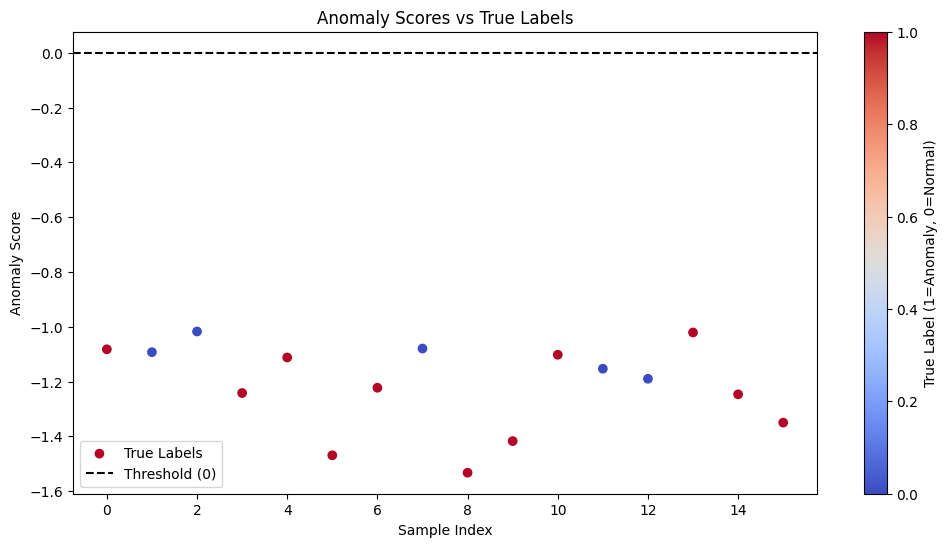

In [37]:
import matplotlib.pyplot as plt

# Plotting the anomaly scores
plt.figure(figsize=(12, 6))

# Scatter plot for anomaly scores
plt.scatter(range(len(anomaly_scores)), anomaly_scores, c=true_labels, cmap='coolwarm', label='True Labels')
plt.axhline(y=0, color='k', linestyle='--', label='Threshold (0)')
plt.title('Anomaly Scores vs True Labels')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score')
plt.colorbar(label='True Label (1=Anomaly, 0=Normal)')
plt.legend()
plt.show()



In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming true_labels are the ground truth labels and anomaly_scores are your predicted scores
# Convert anomaly scores to binary predictions (1 for anomaly, 0 for normal)
threshold = 0.5  # Adjust threshold as needed
predictions = (anomaly_scores < threshold).astype(int)

# Compute metrics
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
accuracy = accuracy_score(true_labels, predictions)

# Print results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 0.6875
Recall: 1.0000
F1 Score: 0.8148
Accuracy: 0.6875


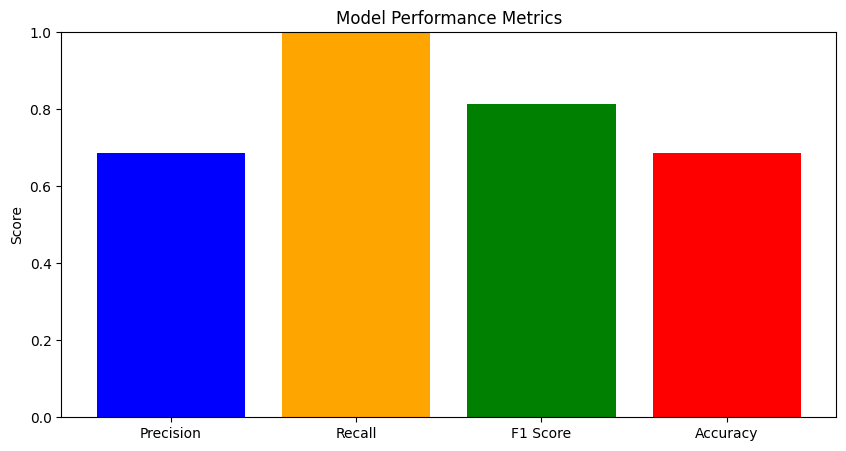

In [39]:
import matplotlib.pyplot as plt

metrics = [precision, recall, f1, accuracy]
metric_names = ['Precision', 'Recall', 'F1 Score', 'Accuracy']

plt.figure(figsize=(10, 5))
plt.bar(metric_names, metrics, color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 1)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.show()


In [47]:
from tensorflow.keras.preprocessing import image
import numpy as np

def load_and_preprocess_image(img_path):
    # Load the image
    img = image.load_img(img_path, target_size=(256, 256))  # Adjust size as needed
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

def predict_anomaly(img_path):
    img_array = load_and_preprocess_image(img_path)

    # Pass the image through the discriminator
    score = discriminator_Y(img_array)

    # Assuming a score < 0.5 indicates an anomaly
    is_anomaly = score < 0.5
    return "Pneumonia" if is_anomaly else "Normal"

# Example usage
result = predict_anomaly(r"C:\Users\sumey\Desktop\babi_project\chest_xray\test\NORMAL\IM-0016-0001.jpeg")
print(result)



Pneumonia


In [49]:
print(type(discriminator_Y))  # This should output <class 'keras.engine.training.Model'>



<class 'keras.src.models.functional.Functional'>


In [50]:
# Save the trained discriminator model
discriminator_Y.save('discriminator_model.h5')
